In [1]:
import torch
import torch_geometric

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import EdgeConv, MessagePassing, EdgePooling
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_scatter import scatter_mean
from torch_geometric.nn.inits import reset
from torch_geometric.data import Dataset, Data, DataLoader

from glob import glob
import numpy as np
import os.path as osp

import math

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [147]:
class PFGraphDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None, connect_all=False, max_elements=None, max_candidates=None):
        self._connect_all = connect_all
        self._max_elements = max_elements
        self._max_candidates = max_candidates
        super(PFGraphDataset, self).__init__(root, transform, pre_transform)
        self.raw_dir = root

    @property
    def raw_file_names(self):
        raw_list = glob(self.raw_dir+'/*ev*.npz')
        return sorted([l.replace(self.raw_dir,'.') for l in raw_list])

    @property
    def processed_file_names(self):
        return ['data_{}.pt'.format(i) for i in range(len(self.raw_file_names))]

    def __len__(self):
        return len(self.processed_file_names)

    def download(self):
        # Download to `self.raw_dir`.
        pass

    def process(self):
        feature_scale = np.array([1., 1., 1., 1., 1., 1., 1., 1.])
        i = 0
        
        for raw_file_name in self.raw_file_names:
            
            dist_file_name = raw_file_name.replace('ev','dist')
            print("loading data from files: {0}, {1}".format(osp.join(self.raw_dir, raw_file_name), osp.join(self.raw_dir, dist_file_name)))
            try:
                fi = np.load(osp.join(self.raw_dir, raw_file_name))
                fi_dist = np.load(osp.join(self.raw_dir, dist_file_name))
            except Exception as e:
                print("Could not open files: {0}, {1}".format(osp.join(self.raw_dir, raw_file_name), osp.join(self.raw_dir, dist_file_name)))
                continue
            
            X_elements = fi['elements'][:self._max_elements]
            X_element_block_id = fi['element_block_id'][:self._max_elements]
            y_candidates = fi['candidates'][:self._max_candidates, 1:]
            y_candidate_block_id = fi['candidate_block_id'][:self._max_candidates]
            num_elements = X_elements.shape[0]

            row_index = fi_dist['row']
            col_index = fi_dist['col']
            num_edges = row_index.shape[0]

            edge_index = np.zeros((2, 2*num_edges))
            edge_index[0,:num_edges] = row_index
            edge_index[1,:num_edges] = col_index
            edge_index[0,num_edges:] = col_index
            edge_index[1,num_edges:] = row_index
            edge_index = torch.tensor(edge_index, dtype=torch.long)

            edge_data = fi_dist['data']
            edge_attr = np.zeros((2*num_edges,1))
            edge_attr[:num_edges,0] = edge_data
            edge_attr[num_edges:,0] = edge_data
            edge_attr = torch.tensor(edge_attr, dtype=torch.float)

            x = torch.tensor(X_elements/feature_scale, dtype=torch.float)

            #y = [X_element_block_id[i]==X_element_block_id[j] for (i,j) in edge_index.t().contiguous()]
            y = torch.tensor(y_candidates, dtype=torch.float)

            data = Data(x=x, edge_index=edge_index, y=y, edge_attr=edge_attr)
            data.x_cluster_labels = torch.tensor(X_element_block_id, dtype=torch.float)
            data.y_cluster_labels = torch.tensor(y_candidate_block_id, dtype=torch.float)
            
            if self.pre_filter is not None and not self.pre_filter(data):
                continue
            if self.pre_transform is not None:
                data = self.pre_transform(data)

            torch.save(data, osp.join(self.processed_dir, 'data_{}.pt'.format(i)))
            i += 1

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, 'data_{}.pt'.format(idx)))
        return data

In [148]:
full_dataset = PFGraphDataset(root='../data/TTbar_run3')

In [149]:
!mkdir ../data/TTBar_run3/processed

mkdir: ../data/TTBar_run3/processed: File exists


In [150]:
full_dataset.process()

loading data from files: ../data/TTbar_run3/./step3_ntuple_1_ev0.npz, ../data/TTbar_run3/./step3_ntuple_1_dist0.npz
loading data from files: ../data/TTbar_run3/./step3_ntuple_1_ev1.npz, ../data/TTbar_run3/./step3_ntuple_1_dist1.npz
loading data from files: ../data/TTbar_run3/./step3_ntuple_1_ev10.npz, ../data/TTbar_run3/./step3_ntuple_1_dist10.npz
loading data from files: ../data/TTbar_run3/./step3_ntuple_1_ev100.npz, ../data/TTbar_run3/./step3_ntuple_1_dist100.npz
loading data from files: ../data/TTbar_run3/./step3_ntuple_1_ev101.npz, ../data/TTbar_run3/./step3_ntuple_1_dist101.npz
loading data from files: ../data/TTbar_run3/./step3_ntuple_1_ev102.npz, ../data/TTbar_run3/./step3_ntuple_1_dist102.npz
loading data from files: ../data/TTbar_run3/./step3_ntuple_1_ev103.npz, ../data/TTbar_run3/./step3_ntuple_1_dist103.npz
loading data from files: ../data/TTbar_run3/./step3_ntuple_1_ev104.npz, ../data/TTbar_run3/./step3_ntuple_1_dist104.npz
loading data from files: ../data/TTbar_run3/./step

loading data from files: ../data/TTbar_run3/./step3_ntuple_1_ev17.npz, ../data/TTbar_run3/./step3_ntuple_1_dist17.npz
loading data from files: ../data/TTbar_run3/./step3_ntuple_1_ev170.npz, ../data/TTbar_run3/./step3_ntuple_1_dist170.npz
loading data from files: ../data/TTbar_run3/./step3_ntuple_1_ev171.npz, ../data/TTbar_run3/./step3_ntuple_1_dist171.npz
loading data from files: ../data/TTbar_run3/./step3_ntuple_1_ev172.npz, ../data/TTbar_run3/./step3_ntuple_1_dist172.npz
loading data from files: ../data/TTbar_run3/./step3_ntuple_1_ev173.npz, ../data/TTbar_run3/./step3_ntuple_1_dist173.npz
loading data from files: ../data/TTbar_run3/./step3_ntuple_1_ev174.npz, ../data/TTbar_run3/./step3_ntuple_1_dist174.npz
loading data from files: ../data/TTbar_run3/./step3_ntuple_1_ev175.npz, ../data/TTbar_run3/./step3_ntuple_1_dist175.npz
loading data from files: ../data/TTbar_run3/./step3_ntuple_1_ev176.npz, ../data/TTbar_run3/./step3_ntuple_1_dist176.npz
loading data from files: ../data/TTbar_run

loading data from files: ../data/TTbar_run3/./step3_ntuple_1_ev61.npz, ../data/TTbar_run3/./step3_ntuple_1_dist61.npz
loading data from files: ../data/TTbar_run3/./step3_ntuple_1_ev62.npz, ../data/TTbar_run3/./step3_ntuple_1_dist62.npz
loading data from files: ../data/TTbar_run3/./step3_ntuple_1_ev63.npz, ../data/TTbar_run3/./step3_ntuple_1_dist63.npz
loading data from files: ../data/TTbar_run3/./step3_ntuple_1_ev64.npz, ../data/TTbar_run3/./step3_ntuple_1_dist64.npz
loading data from files: ../data/TTbar_run3/./step3_ntuple_1_ev65.npz, ../data/TTbar_run3/./step3_ntuple_1_dist65.npz
loading data from files: ../data/TTbar_run3/./step3_ntuple_1_ev66.npz, ../data/TTbar_run3/./step3_ntuple_1_dist66.npz
loading data from files: ../data/TTbar_run3/./step3_ntuple_1_ev67.npz, ../data/TTbar_run3/./step3_ntuple_1_dist67.npz
loading data from files: ../data/TTbar_run3/./step3_ntuple_1_ev68.npz, ../data/TTbar_run3/./step3_ntuple_1_dist68.npz
loading data from files: ../data/TTbar_run3/./step3_ntup

In [151]:
data = full_dataset.get(0)
input_dim = data.x.shape[1]
edge_dim = data.edge_attr.shape[1]
fulllen = len(full_dataset)

tv_frac = 0.10
tv_num = math.ceil(fulllen*tv_frac)
splits = np.cumsum([fulllen-2*tv_num,tv_num,tv_num])

batch_size = 64
n_epochs = 100
lr = 0.01
patience = 10
hidden_dim = 32
n_iters = 1

In [201]:
class EdgeConvWithEdgeAttr(MessagePassing):
    def __init__(self, nn, aggr='max', **kwargs):
        super(EdgeConvWithEdgeAttr, self).__init__(aggr=aggr, **kwargs)
        self.nn = nn
        self.reset_parameters()

    def reset_parameters(self):
        reset(self.nn)

    def forward(self, x, edge_index, edge_attr):
        """"""
        x = x.unsqueeze(-1) if x.dim() == 1 else x
        pseudo = edge_attr.unsqueeze(-1) if edge_attr.dim() == 1 else edge_attr
        return self.propagate(edge_index, x=x, pseudo=pseudo)

    def message(self, x_i, x_j, pseudo):
        return self.nn(torch.cat([x_i, x_j - x_i, pseudo], dim=1))

    def __repr__(self):
        return '{}(nn={})'.format(self.__class__.__name__, self.nn)

class EdgeNet(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=32, edge_dim=1, output_dim=1, n_iters=1, aggr='add'):
        super(EdgeNet, self).__init__()
        
        convnn = nn.Sequential(nn.Linear(2*(hidden_dim + input_dim)+edge_dim, 2*hidden_dim),
                               nn.Tanh(),
                               nn.Linear(2*hidden_dim, hidden_dim),
                               nn.Tanh()
        )
        self.n_iters = n_iters
        
        #self.batchnorm = nn.BatchNorm1d(input_dim)

        self.inputnet =  nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh()
        )

#         self.edgenetwork = nn.Sequential(nn.Linear(2*(hidden_dim+input_dim)+edge_dim,2*hidden_dim),
#                                          nn.ReLU(),
#                                          nn.Linear(2*hidden_dim, output_dim),
#                                          nn.Sigmoid())

        self.nodenetwork = EdgeConvWithEdgeAttr(nn=convnn, aggr=aggr)
        
        self.pooling1 = EdgePooling(40, edge_score_method=EdgePooling.compute_edge_score_tanh)
        self.pooling2 = EdgePooling(40, edge_score_method=EdgePooling.compute_edge_score_tanh)
        
        self.outnetwork = nn.Sequential(nn.Linear(40, 100),
                               nn.Tanh(),
                               nn.Linear(100, 100),
                               nn.Tanh(),
                               nn.Linear(100, 100),
                               nn.Tanh(),
                               nn.Linear(100, 3),
        )

    def forward(self, data):        
        X = data.x
        H = self.inputnet(data.x)
        x = torch.cat([H,X],dim=-1)

        for i in range(self.n_iters):
            H = self.nodenetwork(x, data.edge_index, data.edge_attr)
            x = torch.cat([H,X],dim=-1)

        #row,col = data.edge_index        
        #output = self.edgenetwork(torch.cat([x[row], x[col], data.edge_attr],dim=-1)).squeeze(-1)

        pooled, edge_index, batch, unpool_info1 = self.pooling1(x, data.edge_index, data.batch)
        pooled, edge_index, batch, unpool_info2 = self.pooling2(pooled, edge_index, batch)
        #pooled: (N, 40)
        
        r = self.outnetwork(pooled)
        
        #print(unpool_info)
        #print(x.shape, pooled.shape, r.shape, unpool_info.cluster.shape)
        
        return r, unpool_info1.cluster, unpool_info2.cluster

In [ ]:
train_loader = DataLoader(full_dataset, batch_size=1, pin_memory=True, shuffle=False)
model = EdgeNet(input_dim=input_dim, hidden_dim=hidden_dim, edge_dim=edge_dim, n_iters=n_iters).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss = torch.nn.MSELoss()

print(model)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

model.train()
data = data.to(device)

losses = []
for j in range(100):
    losses_batch = []
    for i in range(50):
        data = full_dataset.get(i)
        data.batch = torch.zeros(data.x.shape[0], dtype=torch.long)
        optimizer.zero_grad()
        batch_target = data.y        
        batch_output, pool_clusters1, pool_clusters2 = model(data)

        n = min(batch_output.shape[0], data.y.shape[0])

        #Compute loss within each block that are known in advance
        batch_loss = []
        
        #loop over all block ids
        for cl in np.unique(data.y_cluster_labels):
            
            #find the elements and candidates corresponding to this block
            m1 = torch.tensor(data.y_cluster_labels == cl)
            m2 = torch.tensor(data.x_cluster_labels == cl)
            
            #get the predicted candidates that use elements from this block
            pred = batch_output[pool_clusters2[pool_clusters1[m2]]]
            tgt = data.y[m1]
            n = min(pred.shape[0], tgt.shape[0])
            batch_loss += [loss(pred[:n], tgt[:n])]
            
        batch_loss = sum(batch_loss)
        batch_loss.backward()
        batch_loss_item = batch_loss.item()
        optimizer.step()

        losses_batch += [batch_loss_item]
    data = full_dataset.get(i)
    data.batch = torch.zeros(data.x.shape[0], dtype=torch.long)
    batch_output = model(data)
    
    l = np.mean(losses_batch)
    losses += [l]
    print(j, l)

EdgeNet(
  (inputnet): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
  )
  (nodenetwork): EdgeConvWithEdgeAttr(nn=Sequential(
    (0): Linear(in_features=81, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Tanh()
  ))
  (pooling1): EdgePooling(40)
  (pooling2): EdgePooling(40)
  (outnetwork): Sequential(
    (0): Linear(in_features=40, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Tanh()
    (6): Linear(in_features=100, out_features=3, bias=True)
  )
)
34493


/Users/joosep/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/joosep/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0 2379.8126672363283
1 1554.1701953125
2 1461.378017578125


In [167]:
import matplotlib.pyplot as plt

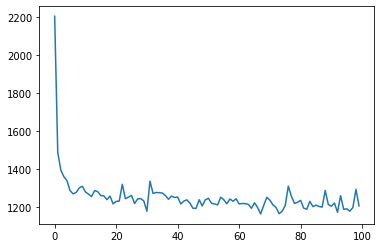

In [168]:
plt.plot(losses)

In [170]:
data = full_dataset.get(i + 1)
data.batch = torch.zeros(data.x.shape[0], dtype=torch.long)
prd = model(data)

In [171]:
# for cl in np.unique(data.y_cluster_labels):
#     m1 = torch.tensor(data.y_cluster_labels == cl)
#     m2 = torch.tensor(data.x_cluster_labels == cl)
#     pred = prd[0][prd[1][m2]]
#     tgt = data.y[m1]
#     print(pred.detach().numpy()[:, 1], tgt.detach().numpy()[:, 1])

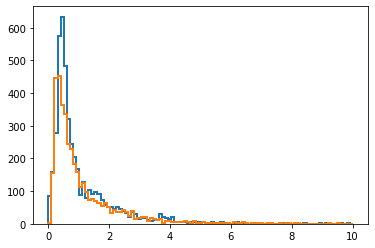

In [172]:
b = np.linspace(0,10,100)
plt.hist(prd[0][:, 0].detach().numpy(), bins=b, lw=2, histtype="step");
plt.hist(data.y[:, 0].detach().numpy(), bins=b, lw=2, histtype="step");

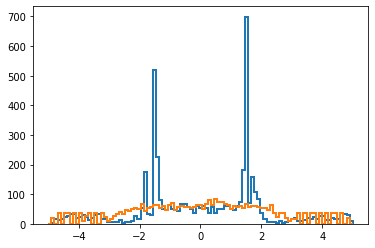

In [174]:
b = np.linspace(-5,5,100)
plt.hist(prd[0][:, 1].detach().numpy(), bins=b, lw=2, histtype="step");
plt.hist(data.y[:, 1].detach().numpy(), bins=b, lw=2, histtype="step");

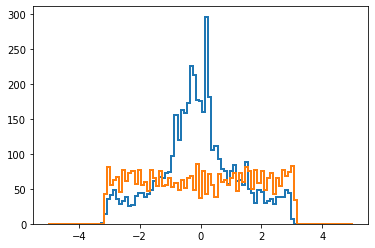

In [175]:
b = np.linspace(-5, 5, 100)
plt.hist(prd[0][:, 2].detach().numpy(), bins=b, lw=2, histtype="step");
plt.hist(data.y[:, 2].detach().numpy(), bins=b, lw=2, histtype="step");